# Querying tables

> Objectives:
> * Compare queries of tabular data for **in-memory** containers
> * Compare sizes and times for those

In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.035 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 34.988 MiB


In [2]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2] used 0.008 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 34.996 MiB


In [3]:
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': object, 'genres': object})

In [3] used 68.676 MiB RAM in 0.640s, peaked 4.945 MiB above current, total RAM usage 103.672 MiB


In [4]:
lens = pd.merge(movies, ratings)

In [4] used 54.250 MiB RAM in 0.098s, peaked 12.320 MiB above current, total RAM usage 157.922 MiB


In [5]:
size_pandas = mw.measurements.memory_delta
size_pandas

54.25

In [5] used 0.082 MiB RAM in 0.025s, peaked 0.000 MiB above current, total RAM usage 158.004 MiB


In [6]:
print(lens[:10])
lens.info()

   movie_id             title                       genres  user_id  rating  \
0         1  Toy Story (1995)  Animation|Children's|Comedy        1       5   
1         1  Toy Story (1995)  Animation|Children's|Comedy        6       4   
2         1  Toy Story (1995)  Animation|Children's|Comedy        8       4   
3         1  Toy Story (1995)  Animation|Children's|Comedy        9       5   
4         1  Toy Story (1995)  Animation|Children's|Comedy       10       5   
5         1  Toy Story (1995)  Animation|Children's|Comedy       18       4   
6         1  Toy Story (1995)  Animation|Children's|Comedy       19       5   
7         1  Toy Story (1995)  Animation|Children's|Comedy       21       3   
8         1  Toy Story (1995)  Animation|Children's|Comedy       23       4   
9         1  Toy Story (1995)  Animation|Children's|Comedy       26       3   

   unix_timestamp  
0       978824268  
1       978237008  
2       978233496  
3       978225952  
4       978226474  
5       97

In [8]:
size_pandas2 = lens.memory_usage().sum() / 2**20.
size_pandas2

53.416923522949219

In [8] used 0.012 MiB RAM in 0.009s, peaked 0.000 MiB above current, total RAM usage 201.465 MiB


In [9]:
result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
t = %timeit -o lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result

10 loops, best of 3: 37.2 ms per loop


5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64

In [9] used 0.969 MiB RAM in 1.658s, peaked 0.000 MiB above current, total RAM usage 202.434 MiB


In [10]:
qtime_pandas = t.best

In [10] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 202.434 MiB


## Use a compressed in-memory container via `bcolz`

In [11]:
import bcolz
bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 5
bcolz.set_nthreads(4)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     1.0.0rc2
NumPy version:     1.10.4
Blosc version:     1.8.0 ($Date:: 2016-03-31 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.5.1
Python version:    2.7.11 |Continuum Analytics, Inc.| (default, Dec  6 2015, 18:08:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux2-x86_64
Byte-ordering:     little
Detected cores:    4
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


4

In [11] used 5.066 MiB RAM in 0.047s, peaked 0.000 MiB above current, total RAM usage 207.500 MiB


In [12]:
zlens = bcolz.ctable.fromdataframe(lens)

In [12] used 0.055 MiB RAM in 0.314s, peaked 78.137 MiB above current, total RAM usage 207.555 MiB


In [13]:
size_bcolz = mw.measurements.memory_delta
size_bcolz

0.0546875

In [13] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 207.555 MiB


Sometimes the memory reported as used is too much biased (don't know why), so let's repeat the operation, but using a different container:

In [14]:
zlens2 = bcolz.ctable.fromdataframe(lens)

In [14] used 2.402 MiB RAM in 0.314s, peaked 76.164 MiB above current, total RAM usage 209.957 MiB


In [15]:
size_bcolz2 = zlens2.cbytes / 2**20.
size_bcolz2

8.014791488647461

In [15] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 209.957 MiB


In [16]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 8.01 MB; ratio: 19.16
  cparams := cparams(clevel=5, shuffle=1, cname='lz4')
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [16] used 0.008 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 209.965 MiB


In [17]:
size_pandas / size_bcolz

992.0

In [17] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 209.965 MiB


We can see that the space taken by a bcolz container is more than 1000x smaller (!) than a pandas one.

### Excercise

Why do you think that the number of uncompressed bytes (nbytes) that the ctable reports is 3x more than pandas (153 MB vs 54 MB)?

*Hint:* Pandas stores the string columns in NumPy containers with 'object' dtype whereas bcolz uses the equivalent to NumPy's 'string' objects.

In [18]:
# Querying a bcolz dataset
resultz = [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]
t = %timeit -o [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]

10 loops, best of 3: 93.1 ms per loop
In [18] used 6.895 MiB RAM in 3.959s, peaked 0.000 MiB above current, total RAM usage 216.859 MiB


In [19]:
qtime_bcolz = t.best

In [19] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 216.859 MiB


In [20]:
qtime_pandas / qtime_bcolz

0.39911570129444535

In [20] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 216.859 MiB


We see that bcolz containers, besides being in compressed state, provide ~1.8x faster query times than pandas

In [21]:
# Sanity check (always check for your results!)
print("results with pandas Dataframe:", result)
print("results with bcolz ctable:", resultz)

('results with pandas Dataframe:', 5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64)
('results with bcolz ctable:', [(5121, 75), (5164, 3842), (5187, 6031)])
In [21] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 216.859 MiB


## Using structured NumPy arrays

In [22]:
nalens = lens.to_records()

In [22] used 53.418 MiB RAM in 0.496s, peaked 0.000 MiB above current, total RAM usage 270.277 MiB


In [23]:
size_numpy = mw.measurements.memory_delta
size_numpy

53.41796875

In [23] used 0.023 MiB RAM in 0.032s, peaked 0.000 MiB above current, total RAM usage 270.301 MiB


In [24]:
nalens

rec.array([ (0, 1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268),
 (1, 1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008),
 (2, 1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496),
 ...,
 (1000206, 3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656),
 (1000207, 3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537),
 (1000208, 3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)], 
          dtype=[('index', '<i8'), ('movie_id', '<i8'), ('title', 'O'), ('genres', 'O'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])

In [24] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 270.301 MiB


In [25]:
size_numpy2 = round((nalens.size * nalens.dtype.itemsize) / 2**20., 3)
size_numpy2

53.417

In [25] used 0.004 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 270.305 MiB


In [26]:
resultna = nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
t = %timeit -o nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
resultna

100 loops, best of 3: 16.3 ms per loop


rec.array([ (5121, 8, 'Tom and Huck (1995)', "Adventure|Children's", 75, 5, 977851520),
 (5164, 8, 'Tom and Huck (1995)', "Adventure|Children's", 3842, 5, 967986151),
 (5187, 8, 'Tom and Huck (1995)', "Adventure|Children's", 6031, 5, 956718223)], 
          dtype=[('index', '<i8'), ('movie_id', '<i8'), ('title', 'O'), ('genres', 'O'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])

In [26] used 4.027 MiB RAM in 6.817s, peaked 0.000 MiB above current, total RAM usage 274.332 MiB


Again, NumPy works the fastest for in-memory data containers, while memory consumption is close to pandas.

In [27]:
qtime_numpy = t.best

In [27] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 274.332 MiB


## Performance comparsion

In [28]:
%matplotlib inline

In [28] used 7.270 MiB RAM in 0.506s, peaked 0.000 MiB above current, total RAM usage 281.602 MiB


/home/faltet/miniconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


/home/faltet/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


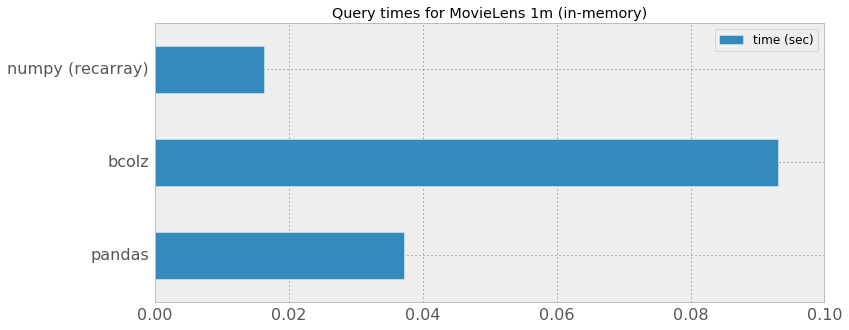

In [29] used 6.547 MiB RAM in 0.642s, peaked 0.000 MiB above current, total RAM usage 288.148 MiB


In [29]:
# Query times
labels = ["pandas", "bcolz", "numpy (recarray)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas, qtime_bcolz, qtime_numpy]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m (in-memory)")

## Size comparison

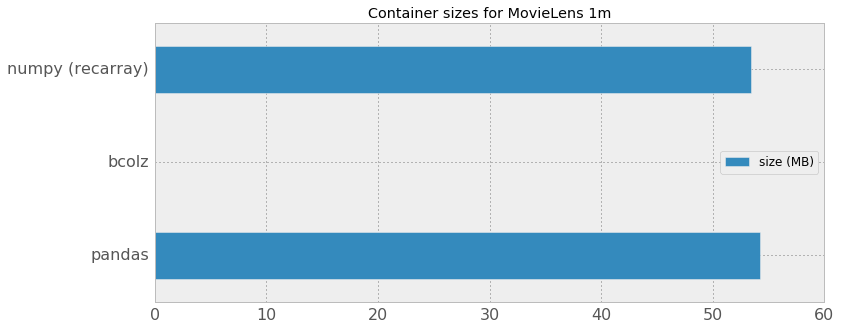

In [30] used 0.859 MiB RAM in 0.319s, peaked 0.000 MiB above current, total RAM usage 289.008 MiB


In [30]:
# Container sizes
df = pd.DataFrame({'size (MB)': [size_pandas, size_bcolz, size_numpy]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

## Rules of thumb for querying in-memory tabular datasets

* Choose pure NumPy recarrays if you need the fastest speed
* Choose bcolz ctables if you need to store lots of data in limited memory and not want to loose too much speed
* Choose pandas if what you need is rich functionality on top of your containers (at the penalty of some speed)